In [223]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.utils import resample


import warnings
warnings.filterwarnings("ignore")


In [224]:
# Read the CSV file
df = pd.read_csv('preprocessed_CRR.csv')

In [225]:
# creating numerical and categorical dataframes
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols


['hotel',
 'arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status_date']

In [226]:
cat_df = df[cat_cols]
cat_df.head()

,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,reservation_status_date
0,Resort Hotel,July,BB,Direct,Direct,C,No Deposit,Transient,2015-07-01
1,Resort Hotel,July,BB,Direct,Direct,C,No Deposit,Transient,2015-07-01
2,Resort Hotel,July,BB,Direct,Direct,A,No Deposit,Transient,2015-07-02
3,Resort Hotel,July,BB,Corporate,Corporate,A,No Deposit,Transient,2015-07-02
4,Resort Hotel,July,BB,Online TA,TA/TO,A,No Deposit,Transient,2015-07-03


In [227]:
cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])

cat_df['year'] = cat_df['reservation_status_date'].dt.year
cat_df['month'] = cat_df['reservation_status_date'].dt.month
cat_df['day'] = cat_df['reservation_status_date'].dt.day

In [228]:

cat_df.drop(['reservation_status_date','arrival_date_month'] , axis = 1, inplace = True)
cat_df.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
0,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015,7,1
1,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015,7,1
2,Resort Hotel,BB,Direct,Direct,A,No Deposit,Transient,2015,7,2
3,Resort Hotel,BB,Corporate,Corporate,A,No Deposit,Transient,2015,7,2
4,Resort Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient,2015,7,3


In [229]:
# encoding categorical variables

cat_df['hotel'] = cat_df['hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})

cat_df['meal'] = cat_df['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

cat_df['market_segment'] = cat_df['market_segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                                                           'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})

cat_df['distribution_channel'] = cat_df['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

cat_df['reserved_room_type'] = cat_df['reserved_room_type'].map({'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6,
                                                                   'L': 7, 'B': 8})

cat_df['deposit_type'] = cat_df['deposit_type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})

cat_df['customer_type'] = cat_df['customer_type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})

cat_df['year'] = cat_df['year'].map({2015: 0, 2014: 1, 2016: 2, 2017: 3})

cat_df.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
0,0,0,0,0,0,0,0,0,7,1
1,0,0,0,0,0,0,0,0,7,1
2,0,0,0,0,1,0,0,0,7,2
3,0,0,1,1,1,0,0,0,7,2
4,0,0,2,2,1,0,0,0,7,3


In [230]:
num_df = df.drop(columns = cat_cols, axis = 1)
num_df.drop('is_canceled', axis = 1, inplace = True)
num_df

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,adr,required_car_parking_spaces,total_of_special_requests
0,342,27,1,0,0,2,0.0,0,0,0,0,0.0,0.0,0.00,0,0
1,737,27,1,0,0,2,0.0,0,0,0,0,0.0,0.0,0.00,0,0
2,7,27,1,0,1,1,0.0,0,0,0,0,0.0,0.0,75.00,0,0
3,13,27,1,0,1,1,0.0,0,0,0,0,304.0,0.0,75.00,0,0
4,14,27,1,0,2,2,0.0,0,0,0,0,240.0,0.0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119205,23,35,30,2,5,2,0.0,0,0,0,0,394.0,0.0,96.14,0,0
119206,102,35,31,2,5,3,0.0,0,0,0,0,9.0,0.0,225.43,0,2
119207,34,35,31,2,5,2,0.0,0,0,0,0,9.0,0.0,157.71,0,4
119208,109,35,31,2,5,2,0.0,0,0,0,0,89.0,0.0,104.40,0,0


In [231]:
num_df.var()


lead_time                         11422.361808
arrival_date_week_number            184.990111
arrival_date_day_of_month            77.107192
stays_in_weekend_nights               0.990258
stays_in_week_nights                  3.599010
adults                                0.330838
children                              0.159070
babies                                0.009508
is_repeated_guest                     0.030507
previous_cancellations                0.713887
previous_bookings_not_canceled        2.244415
agent                             11485.169679
company                            2897.684308
adr                                2543.589039
required_car_parking_spaces           0.060201
total_of_special_requests             0.628652
dtype: float64

In [232]:
# normalizing numerical variables

num_df['lead_time'] = np.log(num_df['lead_time'] + 1)
num_df['arrival_date_week_number'] = np.log(num_df['arrival_date_week_number'] + 1)
num_df['arrival_date_day_of_month'] = np.log(num_df['arrival_date_day_of_month'] + 1)
num_df['agent'] = np.log(num_df['agent'] + 1)
num_df['company'] = np.log(num_df['company'] + 1)
num_df['adr'] = np.log(num_df['adr'] + 1)


num_df.var()


lead_time                         2.582757
arrival_date_week_number          0.440884
arrival_date_day_of_month         0.506325
stays_in_weekend_nights           0.990258
stays_in_week_nights              3.599010
adults                            0.330838
children                          0.159070
babies                            0.009508
is_repeated_guest                 0.030507
previous_cancellations            0.713887
previous_bookings_not_canceled    2.244415
agent                             3.535793
company                           1.346883
adr                               0.515480
required_car_parking_spaces       0.060201
total_of_special_requests         0.628652
dtype: float64

In [233]:
num_df['adr'] = num_df['adr'].fillna(value = num_df['adr'].mean())

num_df.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,adr,required_car_parking_spaces,total_of_special_requests
0,5.837730,3.332205,0.693147,0,0,2,0.0,0,0,0,0,0.000000,0.0,0.000000,0,0
1,6.603944,3.332205,0.693147,0,0,2,0.0,0,0,0,0,0.000000,0.0,0.000000,0,0
2,2.079442,3.332205,0.693147,0,1,1,0.0,0,0,0,0,0.000000,0.0,4.330733,0,0
3,2.639057,3.332205,0.693147,0,1,1,0.0,0,0,0,0,5.720312,0.0,4.330733,0,0
4,2.708050,3.332205,0.693147,0,2,2,0.0,0,0,0,0,5.484797,0.0,4.595120,0,1


In [234]:
X = pd.concat([cat_df, num_df], axis = 1)
y = df['is_canceled']

X.shape, y.shape


((119210, 26), (119210,))

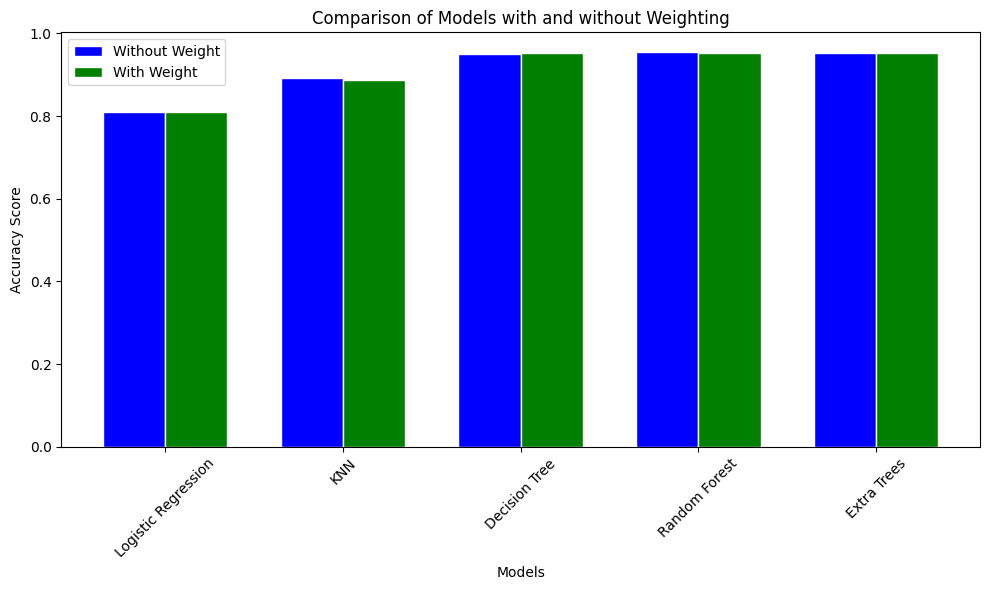

Logistic Regression without weight:
Accuracy Score: 0.8098034281240388
Confusion Matrix:
[[21250  1211]
 [ 5591  7711]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86     22461
           1       0.86      0.58      0.69     13302

    accuracy                           0.81     35763
   macro avg       0.83      0.76      0.78     35763
weighted avg       0.82      0.81      0.80     35763


Logistic Regression with weight:
Accuracy Score: 0.8092162290635573
Confusion Matrix:
[[21313  1148]
 [ 5675  7627]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86     22461
           1       0.87      0.57      0.69     13302

    accuracy                           0.81     35763
   macro avg       0.83      0.76      0.78     35763
weighted avg       0.82      0.81      0.80     35763


KNN without weight:
Accuracy Score: 0.8922349914716327
Confus

In [235]:
# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Define weights for important columns
weights = {
    'lead_time': 2.0,
    'is_repeated_guest': 1.5,
    'previous_bookings_not_canceled': 1.2,
    'adr': 1.3
}

# Apply weights to the training set
X_train_weighted = X_train.copy()
X_train_weighted.loc[:, ['lead_time', 'is_repeated_guest', 'previous_bookings_not_canceled', 'adr']] *= weights

# Apply weights to the test set
X_test_weighted = X_test.copy()
X_test_weighted.loc[:, ['lead_time', 'is_repeated_guest', 'previous_bookings_not_canceled', 'adr']] *= weights

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Logistic Regression with weights
lr_weighted = LogisticRegression()
lr_weighted.fit(X_train_weighted, y_train)
y_pred_lr_weighted = lr_weighted.predict(X_test_weighted)

# KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# KNN with weights
knn_weighted = KNeighborsClassifier()
knn_weighted.fit(X_train_weighted, y_train)
y_pred_knn_weighted = knn_weighted.predict(X_test_weighted)

# Decision Tree Classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

# Decision Tree Classifier with weights
dtc_weighted = DecisionTreeClassifier()
dtc_weighted.fit(X_train_weighted, y_train)
y_pred_dtc_weighted = dtc_weighted.predict(X_test_weighted)

# Random Forest Classifier
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)
y_pred_rd_clf = rd_clf.predict(X_test)

# Random Forest Classifier with weights
rd_clf_weighted = RandomForestClassifier()
rd_clf_weighted.fit(X_train_weighted, y_train)
y_pred_rd_clf_weighted = rd_clf_weighted.predict(X_test_weighted)

# Extra Trees Classifier
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
y_pred_etc = etc.predict(X_test)

# Extra Trees Classifier with weights
etc_weighted = ExtraTreesClassifier()
etc_weighted.fit(X_train_weighted, y_train)
y_pred_etc_weighted = etc_weighted.predict(X_test_weighted)

# Accuracy scores
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_lr_weighted = accuracy_score(y_test, y_pred_lr_weighted)
acc_knn = accuracy_score(y_test, y_pred_knn)
acc_knn_weighted = accuracy_score(y_test, y_pred_knn_weighted)
acc_dtc = accuracy_score(y_test, y_pred_dtc)
acc_dtc_weighted = accuracy_score(y_test, y_pred_dtc_weighted)
acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)
acc_rd_clf_weighted = accuracy_score(y_test, y_pred_rd_clf_weighted)
acc_etc = accuracy_score(y_test, y_pred_etc)
acc_etc_weighted = accuracy_score(y_test, y_pred_etc_weighted)

# Confusion matrices
conf_lr = confusion_matrix(y_test, y_pred_lr)
conf_lr_weighted = confusion_matrix(y_test, y_pred_lr_weighted)
conf_knn = confusion_matrix(y_test, y_pred_knn)
conf_knn_weighted = confusion_matrix(y_test, y_pred_knn_weighted)
conf_dtc = confusion_matrix(y_test, y_pred_dtc)
conf_dtc_weighted = confusion_matrix(y_test, y_pred_dtc_weighted)
conf_rd_clf = confusion_matrix(y_test, y_pred_rd_clf)
conf_rd_clf_weighted = confusion_matrix(y_test, y_pred_rd_clf_weighted)
conf_etc = confusion_matrix(y_test, y_pred_etc)
conf_etc_weighted = confusion_matrix(y_test, y_pred_etc_weighted)

# Classification reports
clf_report_lr = classification_report(y_test, y_pred_lr)
clf_report_lr_weighted = classification_report(y_test, y_pred_lr_weighted)
clf_report_knn = classification_report(y_test, y_pred_knn)
clf_report_knn_weighted = classification_report(y_test, y_pred_knn_weighted)
clf_report_dtc = classification_report(y_test, y_pred_dtc)
clf_report_dtc_weighted = classification_report(y_test, y_pred_dtc_weighted)
clf_report_rd_clf = classification_report(y_test, y_pred_rd_clf)
clf_report_rd_clf_weighted = classification_report(y_test, y_pred_rd_clf_weighted)
clf_report_etc = classification_report(y_test, y_pred_etc)
clf_report_etc_weighted = classification_report(y_test, y_pred_etc_weighted)

# Models comparison
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Extra Trees']
scores = [acc_lr, acc_knn, acc_dtc, acc_rd_clf, acc_etc]
weighted_scores = [acc_lr_weighted, acc_knn_weighted, acc_dtc_weighted, acc_rd_clf_weighted, acc_etc_weighted]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Plot the bars
plt.figure(figsize=(10, 6))
plt.bar(r1, scores, color='b', width=bar_width, edgecolor='white', label='Without Weight')
plt.bar(r2, weighted_scores, color='g', width=bar_width, edgecolor='white', label='With Weight')

# Add labels, title, and ticks
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Models with and without Weighting')
plt.xticks([r + bar_width/2 for r in range(len(models))], models, rotation=45)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Print results
print('Logistic Regression without weight:')
print(f"Accuracy Score: {acc_lr}")
print(f"Confusion Matrix:\n{conf_lr}")
print(f"Classification Report:\n{clf_report_lr}\n")

print('Logistic Regression with weight:')
print(f"Accuracy Score: {acc_lr_weighted}")
print(f"Confusion Matrix:\n{conf_lr_weighted}")
print(f"Classification Report:\n{clf_report_lr_weighted}\n")

print('KNN without weight:')
print(f"Accuracy Score: {acc_knn}")
print(f"Confusion Matrix:\n{conf_knn}")
print(f"Classification Report:\n{clf_report_knn}\n")

print('KNN with weight:')
print(f"Accuracy Score: {acc_knn_weighted}")
print(f"Confusion Matrix:\n{conf_knn_weighted}")
print(f"Classification Report:\n{clf_report_knn_weighted}\n")

print('Decision Tree without weight:')
print(f"Accuracy Score: {acc_dtc}")
print(f"Confusion Matrix:\n{conf_dtc}")
print(f"Classification Report:\n{clf_report_dtc}\n")

print('Decision Tree with weight:')
print(f"Accuracy Score: {acc_dtc_weighted}")
print(f"Confusion Matrix:\n{conf_dtc_weighted}")
print(f"Classification Report:\n{clf_report_dtc_weighted}\n")

print('Random Forest without weight:')
print(f"Accuracy Score: {acc_rd_clf}")
print(f"Confusion Matrix:\n{conf_rd_clf}")
print(f"Classification Report:\n{clf_report_rd_clf}\n")

print('Random Forest with weight:')
print(f"Accuracy Score: {acc_rd_clf_weighted}")
print(f"Confusion Matrix:\n{conf_rd_clf_weighted}")
print(f"Classification Report:\n{clf_report_rd_clf_weighted}\n")

print('Extra Trees without weight:')
print(f"Accuracy Score: {acc_etc}")
print(f"Confusion Matrix:\n{conf_etc}")
print(f"Classification Report:\n{clf_report_etc}\n")

print('Extra Trees with weight:')
print(f"Accuracy Score: {acc_etc_weighted}")
print(f"Confusion Matrix:\n{conf_etc_weighted}")
print(f"Classification Report:\n{clf_report_etc_weighted}\n")

In [240]:
# Splitting data into training set and test set
test_sizes = [0.2, 0.3, 0.4, 0.5]  # Different test set sizes
results = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Logistic Regression
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    acc_lr = accuracy_score(y_test, y_pred_lr)

    # KNN
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    acc_knn = accuracy_score(y_test, y_pred_knn)

    # Decision Tree Classifier
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train, y_train)
    y_pred_dtc = dtc.predict(X_test)
    acc_dtc = accuracy_score(y_test, y_pred_dtc)

    # Random Forest Classifier
    rd_clf = RandomForestClassifier()
    rd_clf.fit(X_train, y_train)
    y_pred_rd_clf = rd_clf.predict(X_test)
    acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)

    # Extra Trees Classifier
    etc = ExtraTreesClassifier()
    etc.fit(X_train, y_train)
    y_pred_etc = etc.predict(X_test)
    acc_etc = accuracy_score(y_test, y_pred_etc)

    results.append({
        'Test Size': test_size,
        'Logistic Regression': acc_lr,
        'KNN': acc_knn,
        'Decision Tree': acc_dtc,
        'Random Forest': acc_rd_clf,
        'Extra Trees': acc_etc
    })

# Convert results to dataframe
results_df = pd.DataFrame(results)

# Rank algorithms based on their accuracy scores
ranked_results = results_df.iloc[:, 1:].rank(ascending=False, method='min')

# Add ranking to the results dataframe
results_df['Rank'] = ranked_results.mean(axis=1)

# Sort the results dataframe by rank
results_df = results_df.sort_values('Rank')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Test Size'], results_df['Logistic Regression'], marker='o', label='Logistic Regression')
plt.plot(results_df['Test Size'], results_df['KNN'], marker='o', label='KNN')
plt.plot(results_df['Test Size'], results_df['Decision Tree'], marker='o', label='Decision Tree')
plt.plot(results_df['Test Size'], results_df['Random Forest'], marker='o', label='Random Forest')
plt.plot(results_df['Test Size'], results_df['Extra Trees'], marker='o', label='Extra Trees')
plt.xlabel('Test Size')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score dhe Test Size per Algoritme te Ndryshme')
plt.legend()
plt.show()

# Print results
print(results_df)